In [110]:
#pip install opendatasets
import opendatasets as od
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [ ]:
#provide the credentials for kaggle and download the dataset
od.download(
    "https://www.kaggle.com/datasets/CooperUnion/cardataset/data")

os.listdir(".\cardataset")
raw_df = pd.read_csv("cardataset/data.csv")
df = raw_df.copy()

#incase of deleting the  dataset
# import shutil
# shutil.rmtree(".\cardataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/CooperUnion/cardataset


100%|███████████████████████████████████████████████████████████████████████████████████████| 103k/103k [00:00<?, ?B/s]

In [ ]:
# training data and testing data split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
# manual lable coding but can be done using sklearn's OneHotEncoder

# # label ending for categorical features
# df["Make"].value_counts()
# make_name = list(df["Make"].value_counts().index)
# make_mapping = {name: idx for idx, name in enumerate(make_name)}
# df["Make_id"] = df["Make"].map(make_mapping)
# #-------------------------------------------------------------
# model_name = list(df["Model"].value_counts().index)
# model_mapping = {name: idx for idx, name in enumerate(model_name)}
# df["Model_id"] = df["Model"].map(model_mapping)
# #-------------------------------------------------------------
# fuel_types = list(df["Engine Fuel Type"].value_counts().index)
# fuel_mapping = {name: idx for idx, name in enumerate(fuel_types)}
# df["FuelType_id"] = df["Engine Fuel Type"].map(fuel_mapping)
# #-------------------------------------------------------------
# trans_types = list(df["Transmission Type"].value_counts().index)
# trans_mapping = {name: idx for idx, name in enumerate(trans_types)}
# df["Transmission_id"] = df["Transmission Type"].map(trans_mapping)
# #-------------------------------------------------------------
# drive_types = list(df["Driven_Wheels"].value_counts().index)
# drive_mapping = {name: idx for idx, name in enumerate(drive_types)}
# df["DrivenWheels_id"] = df["Driven_Wheels"].map(drive_mapping)
# #-------------------------------------------------------------
# size_types = list(df["Vehicle Size"].value_counts().index)
# size_mapping = {name: idx for idx, name in enumerate(size_types)}
# df["VehicleSize_id"] = df["Vehicle Size"].map(size_mapping)
# #-------------------------------------------------------------
# style_types = list(df["Vehicle Style"].value_counts().index)
# style_mapping = {name: idx for idx, name in enumerate(style_types)}
# df["VehicleStyle_id"] = df["Vehicle Style"].map(style_mapping)

# manual lable coding but can be done using sklearn's OneHotEncoder

In [ ]:

# multiple label encoding for "Market Category"
market_cat = train_set["Market Category"].apply(lambda x: x.split(',') if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()
market_cat_encoded = mlb.fit_transform(market_cat)
market_cat_df = pd.DataFrame(market_cat_encoded, columns=mlb.classes_, index=train_set.index)


In [ ]:
# Function to perform multi-label encoding for "Market Category"
def multi_label_encode(train_set):
    market_cat = train_set["Market Category"].apply(lambda x: x.split(',') if isinstance(x, str) else [])
    mlb = MultiLabelBinarizer()
    market_cat_encoded = mlb.fit_transform(market_cat)
    market_cat_df = pd.DataFrame(market_cat_encoded, columns=mlb.classes_, index=train_set.index)
    return market_cat_df

In [ ]:
# pipelines for numerical and categorical features
#-------------------------------------------------------------

cat = ["Make","Model","Engine Fuel Type","Transmission Type", "Driven_Wheels", "Vehicle Size", "Vehicle Style"] 
num = ["Engine HP", "Year", "Popularity","highway MPG","Engine Cylinders", "city mpg", "Popularity" ]
multi_features = ["Market Category"]
target = ["MSRP"]
#-------------------------------------------------------------
#numerical features
numerical_pipline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("std_scaler", StandardScaler())
        
    ]
)
#-------------------------------------------------------------
#categorical features
categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
#-------------------------------------------------------------
# full pipeline combination

full_pipeline = ColumnTransformer(
    [
        ("num", numerical_pipline, num),  
        ("cat", categorical_pipeline, cat),
    ]
)

In [ ]:
# training data preparation
#-------------------------------------------------------------
# market category encoding
market_cat_df = multi_label_encode(train_set)
df_x = train_set.drop(columns=["MSRP", "Market Category"])

df_y = train_set[target]

cleaned_df = full_pipeline.fit_transform(df_x)
if hasattr(cleaned_df, "toarray"):
    cleaned_df = cleaned_df.toarray()
if cleaned_df.ndim == 1:
    cleaned_df = cleaned_df.reshape(-1, 1)
final_cleaned_df = np.hstack([cleaned_df, market_cat_df.values])




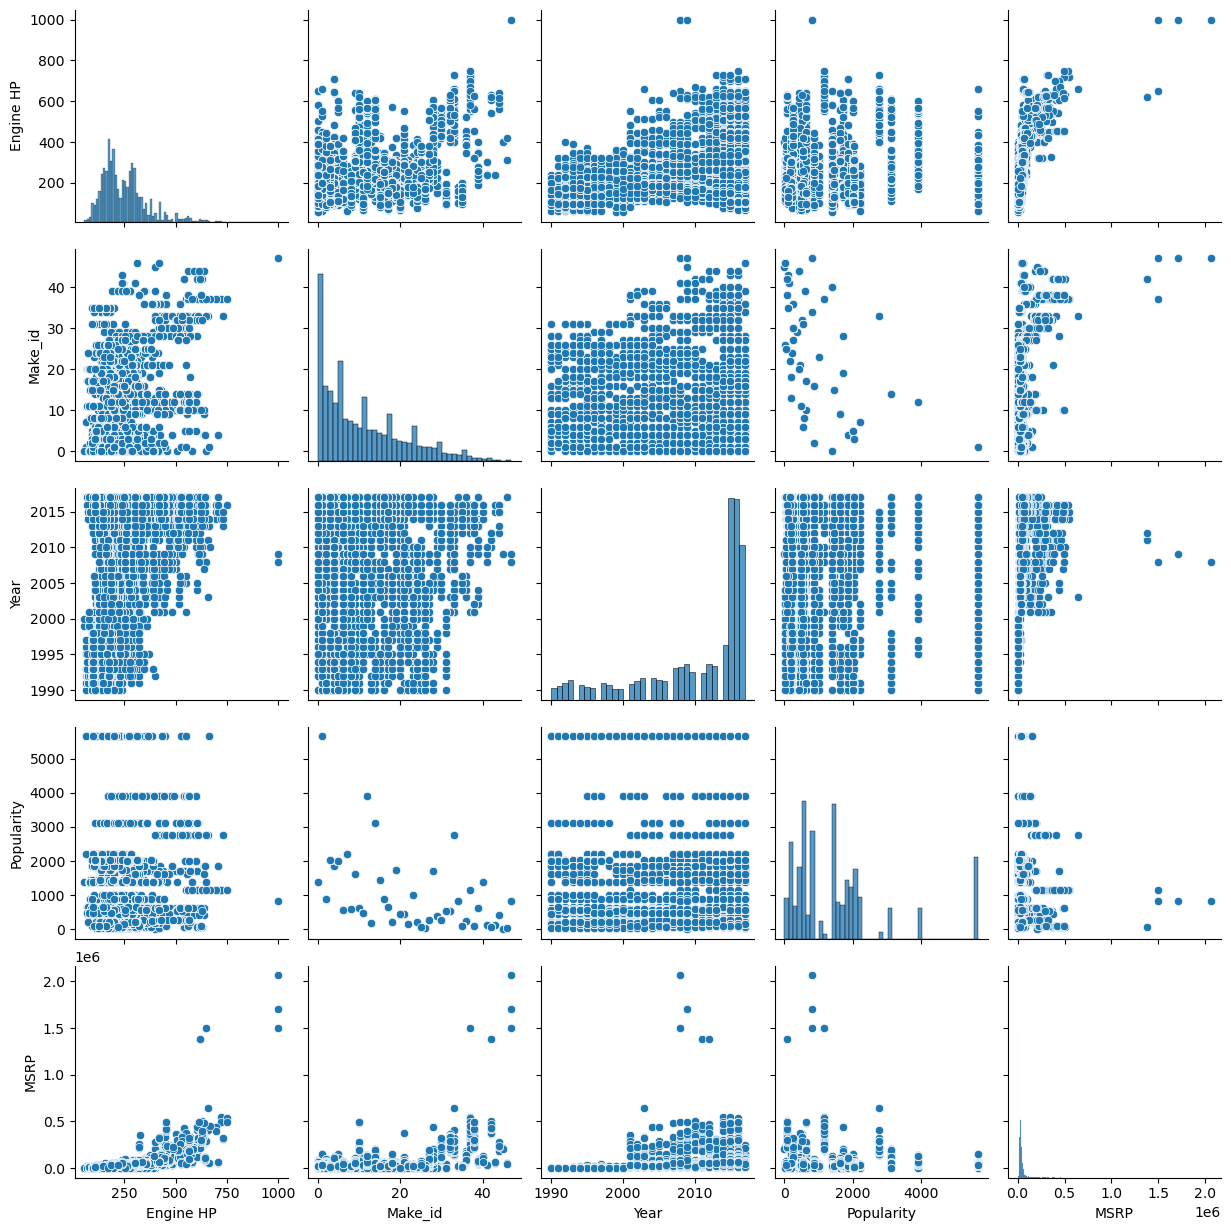

In [ ]:
# potential important features
features = ["Engine HP", "Make_id", "Year", "Popularity",  "MSRP"]
sns.pairplot(df[features])

In [ ]:
# training both models (DEcision Tree and Random Forest)
model1=DecisionTreeRegressor()
model1.fit(final_cleaned_df, df_y)
model2 = RandomForestRegressor(n_estimators=100, random_state=42)
model2.fit(final_cleaned_df, df_y)

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [ ]:
# cost values without hyperparameters tuning
predictions_model1 = model1.predict(final_cleaned_df)
predictions_model2 = model2.predict(final_cleaned_df)

mse_model1 = mean_squared_error(df_y, predictions_model1)
mse_model2 = mean_squared_error(df_y, predictions_model2)
print(f"Decision Tree MSE: {mse_model1}")
print(f"Random Forest MSE: {mse_model2}")

Decision Tree MSE: 23630872.83805918
Random Forest MSE: 43292346.69932133


In [ ]:
# hyperparameters tuning for Random Forest
from sklearn.model_selection import GridSearchCV
model_rf = RandomForestRegressor(random_state=42)

param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
grid_search = GridSearchCV(model_rf, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(final_cleaned_df, df_y)


In [ ]:
# hyperparameters tuning for Decision Tree
model_dt = DecisionTreeRegressor(random_state=42)

param_grid_dt = {
    'max_depth': [5, 10, 20, None],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_dt = GridSearchCV(
    model_dt,
    param_grid_dt,
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True
)

grid_search_dt.fit(final_cleaned_df, df_y)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\Lib\site-packag

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=42),
             param_grid={'max_depth': [5, 10, 20, None],
                         'max_features': [None, 'auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
#  checking best parameters and final model performance on training data
print("Decison Tree regressor best parameters:", grid_search_dt.best_params_)
final_model = grid_search_dt.best_estimator_
final_predictions = final_model.predict(final_cleaned_df)
final_mse = mean_squared_error(df_y, final_predictions)
print(f"Final Decision Tree MSE: {np.sqrt(final_mse)}")

some_data = final_cleaned_df[:5]
some_predictions = final_model.predict(some_data)
target_values = df_y[:5].values.flatten()
print("Target values:", target_values)
print("Some predictions:", some_predictions)

# Save the final model
import joblib
joblib.dump(final_model, "final_decision_tree_model.pkl")
print("Model saved")



Decison Tree regressor best parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Final Decision Tree MSE: 5418.291307558287
Target values: [53495 93850 19890  2000 21270]
Some predictions: [55945.       90587.5      19715.        2002.609375 21070.      ]
Model saved as final_decision_tree_model.pkl


In [ ]:
# loading the model and testing on test set
final_model = joblib.load("final_decision_tree_model.pkl")

X_test = test_set.drop(columns=["MSRP", "Market Category"])
y_test = test_set["MSRP"]


X_test_prepared = full_pipeline.transform(X_test)

multi_tester = multi_label_encode(test_set)


if hasattr(X_test_prepared, "toarray"):
    X_test_prepared = X_test_prepared.toarray()
if X_test_prepared.ndim == 1:
    X_test_prepared = X_test_prepared.reshape(-1, 1)

final_cleaned_tester = np.hstack([X_test_prepared, multi_tester.values])


predictions = final_model.predict(final_cleaned_tester)

mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Test MSE:", mse)
print("Test RMSE:", rmse)


Test MSE: 154508180.85069132
Test RMSE: 12430.131972376292


In [136]:
actual = y_test.values.flatten()

# Avoid division by zero (filter out or handle separately if needed)
percentage_error = np.abs((actual - predictions) / actual) * 100

# Print individual errors for first 10 (or all if small dataset)
for i in range(10):  # or use len(actual) for full set
    print(f"Sample {i+1}: Actual = {actual[i]:,.0f}, Predicted = {predictions[i]:,.0f}, Error = {percentage_error[i]:.2f}%")

# Average % error (MAPE)
mape = np.mean(percentage_error)
print(f"\nMean Absolute Percentage Error (MAPE): {mape:.2f}%")

Sample 1: Actual = 29,695, Predicted = 33,847, Error = 13.98%
Sample 2: Actual = 30,495, Predicted = 26,481, Error = 13.16%
Sample 3: Actual = 37,650, Predicted = 34,461, Error = 8.47%
Sample 4: Actual = 16,170, Predicted = 18,405, Error = 13.82%
Sample 5: Actual = 2,000, Predicted = 2,003, Error = 0.13%
Sample 6: Actual = 19,299, Predicted = 17,774, Error = 7.90%
Sample 7: Actual = 42,600, Predicted = 43,030, Error = 1.01%
Sample 8: Actual = 2,384, Predicted = 2,137, Error = 10.38%
Sample 9: Actual = 2,000, Predicted = 2,019, Error = 0.96%
Sample 10: Actual = 17,995, Predicted = 20,905, Error = 16.17%

Mean Absolute Percentage Error (MAPE): 7.49%


In [ ]:
# Few predictions and Target values
some_data = final_cleaned_tester[:10]
some_predictions = final_model.predict(some_data)
target_values = y_test[:10].values.flatten()
print("Target values:", target_values)
print("Some predictions:", some_predictions)

Target values: [29695 30495 37650 16170  2000 19299 42600  2384  2000 17995]
Some predictions: [33846.875      26481.         34460.5033557  18405.
  2002.609375   17774.         43030.          2136.57142857
  2019.11214953 20905.08333333]
